In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4,InceptionV3
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, Accuracy, BinaryAccuracy, Precision, Recall, AUC, SpecificityAtSensitivity
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def show_images(path, num_images, num_rows, num_cols):
    count = 0
    sizes = []
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    for filename in os.listdir(path):
        if count < num_images and (filename.endswith(".jpg") or filename.endswith(".png")):
            img = Image.open(os.path.join(path, filename))
            img = img.convert('RGB')

            size = img.size
            sizes.append(size)

            row = count // num_cols
            col = count % num_cols
            axs[row, col].imshow(img)
            axs[row, col].axis('off')
            count += 1
        elif count >= num_images:
            break

    #avg_size = np.array(sizes).mean(axis=0)
    #avg_size = np.ceil(avg_size / 32) * 32
    #print("Average image size: ", avg_size)

    plt.show()

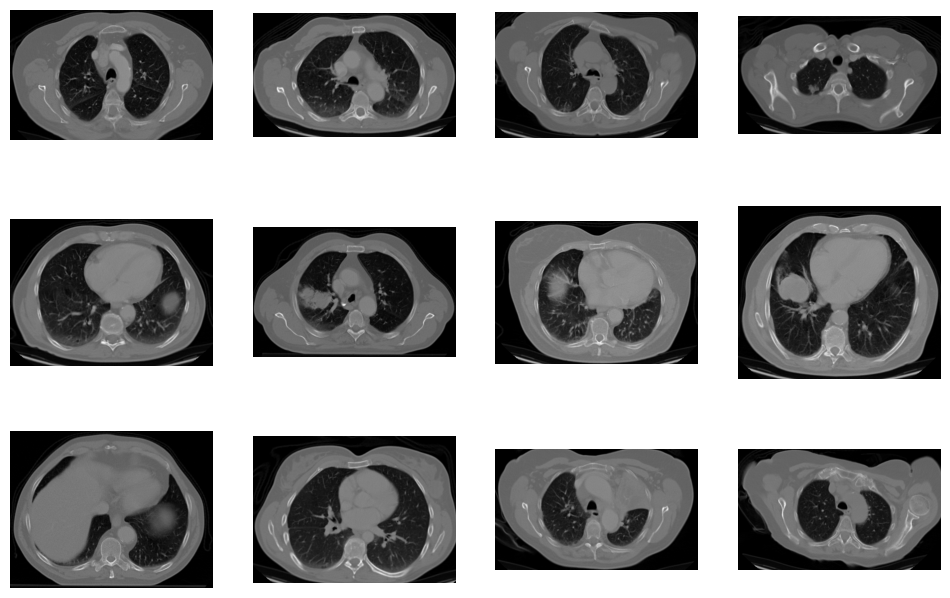

In [4]:
show_images("Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib", 12, 3, 4)

#### Base models

In [25]:
def f_model(model):
    checkpoint = ModelCheckpoint('model.hdf5',verbose = 1, save_best_only=True, monitor='val_loss', mode='min')
    early_stopping = EarlyStopping(monitor = 'val_loss', patience= 20)
    lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

    metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
               FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
               Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
    history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset,
                        callbacks = [checkpoint, early_stopping, lrd])
    return history

In [26]:
def plot_loss(x):
    plt.figure(figsize=(7, 5))
    plt.semilogy(x.epoch,  x.history['loss'], color='red',
                 label='Train Model')
    plt.semilogy(x.epoch,  x.history['val_loss'], color='blue',
                 label='Val Model', linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

In [27]:
def plot_metrics(x):
    metrics =  ['accuracy', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
    plt.figure(figsize=(10, 8))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3, 2, n+1)
        plt.plot(x.epoch,  x.history[metric], color='red', label='Train')
        plt.plot(x.epoch, x.history['val_'+metric], color='blue', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()
    plt.show()

In [28]:
train_datagen = ImageDataGenerator(dtype='float32', rescale = 1./255, validation_split = 0.2, rotation_range=15,
                                   width_shift_range=0.1, height_shift_range=0.1, brightness_range=[0.4, 1.2],
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(dtype='float32', rescale = 1./255, validation_split = 0.2)

test_datagen  = ImageDataGenerator(dtype='float32', rescale = 1./255)

In [29]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Data/train', target_size = (224,224), class_mode = 'categorical', batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = 'Data/valid', target_size = (224,224), class_mode = 'categorical', batch_size = 8)

test_dataset = test_datagen.flow_from_directory(directory = 'Data/test', target_size = (224,224), class_mode = 'categorical', batch_size = 16)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [30]:
model1 = Sequential()
model1.add(Conv2D(8, kernel_size=(3, 3), input_shape=(224,224,3), padding='same', activation='relu', data_format='channels_last'))
model1.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.3))
model1.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.4))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(4, activation='softmax'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 8)       224       
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 16)      1168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 112, 112, 16)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      9280      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

In [31]:
fm_1=f_model(model1)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.8224 - tp: 83.0000 - fp: 129.0000 - tn: 1710.0000 - fn: 530.0000 - accuracy: 0.7312 - precision: 0.3915 - recall: 0.1354 - auc: 0.5632 - sensitivity: 0.2403
Epoch 1: val_loss improved from inf to 1.40171, saving model to model.hdf5
20/20 [==============================] - 11s 484ms/step - loss: 1.8224 - tp: 83.0000 - fp: 129.0000 - tn: 1710.0000 - fn: 530.0000 - accuracy: 0.7312 - precision: 0.3915 - recall: 0.1354 - auc: 0.5632 - sensitivity: 0.2403 - val_loss: 1.4017 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 72.0000 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6678 - val_sensitivity: 0.3472 - lr: 0.0010
Epoch 2/100
19/20 [===========================>..] - ETA: 0s - loss: 1.2921 - tp: 37.0000 - fp: 14.0000 - tn: 1810.0000 - fn: 571.0000 - accuracy: 0.7595 - precision: 0.7255 - recall: 0.0609 - auc: 0.6897 - sensitivity: 0.4770
Epoch 2: val_los

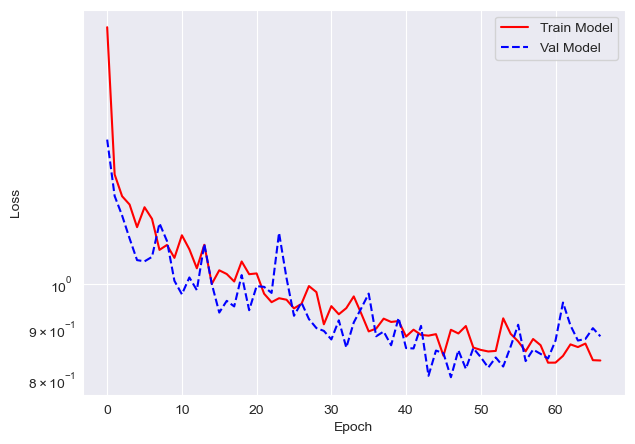

In [32]:
plot_loss(fm_1)

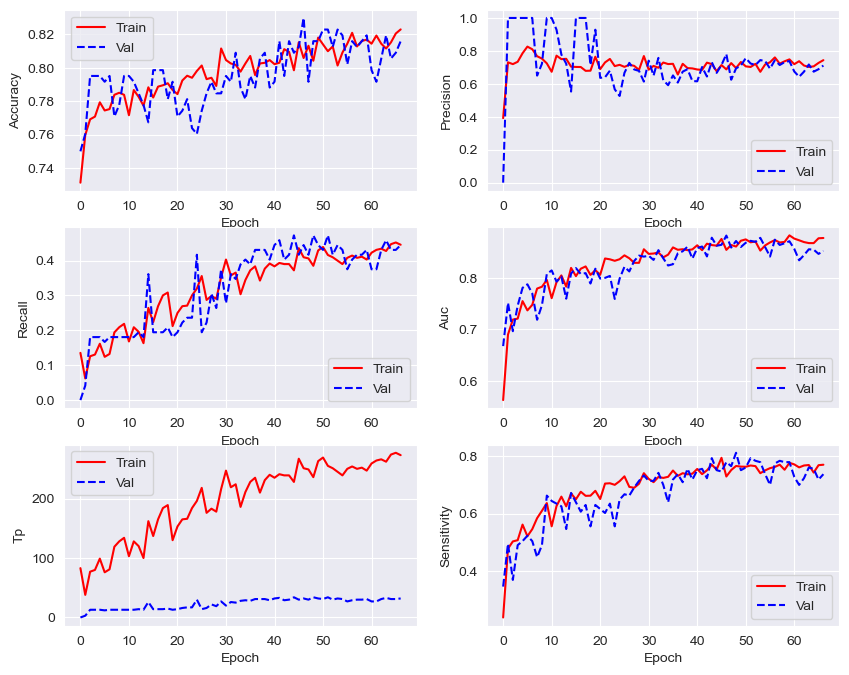

In [33]:
plot_metrics(fm_1)

In [34]:
result1 = model1.evaluate(test_dataset)

20/20 [==============================] - 2s 76ms/step - loss: 2.1750 - tp: 61.0000 - fp: 162.0000 - tn: 783.0000 - fn: 254.0000 - accuracy: 0.6698 - precision: 0.2735 - recall: 0.1937 - auc: 0.5497 - sensitivity: 0.2614


In [35]:
model1_b = load_model('model.hdf5')
print('Best model from file:')
result1_b = model1_b.evaluate(test_dataset)

Best model from file:
20/20 [==============================] - 2s 74ms/step - loss: 1.8154 - tp: 63.0000 - fp: 114.0000 - tn: 831.0000 - fn: 252.0000 - accuracy: 0.7095 - precision: 0.3559 - recall: 0.2000 - auc: 0.5947 - sensitivity: 0.2995


In [36]:
model2 = Sequential()
model2.add(Conv2D(8, kernel_size=(3, 3), input_shape=(224, 224,3), padding='same', activation='relu', data_format='channels_last'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.35))

model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(4, activation='softmax'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 8)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 32)      2336      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 56, 56, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 100352)           

In [37]:
fm_2=f_model(model2)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.6377 - tp: 63.0000 - fp: 107.0000 - tn: 1732.0000 - fn: 550.0000 - accuracy: 0.7321 - precision: 0.3706 - recall: 0.1028 - auc: 0.5730 - sensitivity: 0.2224
Epoch 1: val_loss improved from inf to 1.22173, saving model to model.hdf5
20/20 [==============================] - 12s 538ms/step - loss: 1.6377 - tp: 63.0000 - fp: 107.0000 - tn: 1732.0000 - fn: 550.0000 - accuracy: 0.7321 - precision: 0.3706 - recall: 0.1028 - auc: 0.5730 - sensitivity: 0.2224 - val_loss: 1.2217 - val_tp: 12.0000 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 60.0000 - val_accuracy: 0.7917 - val_precision: 1.0000 - val_recall: 0.1667 - val_auc: 0.5568 - val_sensitivity: 0.3287 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.1980 - tp: 89.0000 - fp: 35.0000 - tn: 1804.0000 - fn: 524.0000 - accuracy: 0.7720 - precision: 0.7177 - recall: 0.1452 - auc: 0.7282 - sensitivity: 0.5117
Epoch 2: val_loss improved 

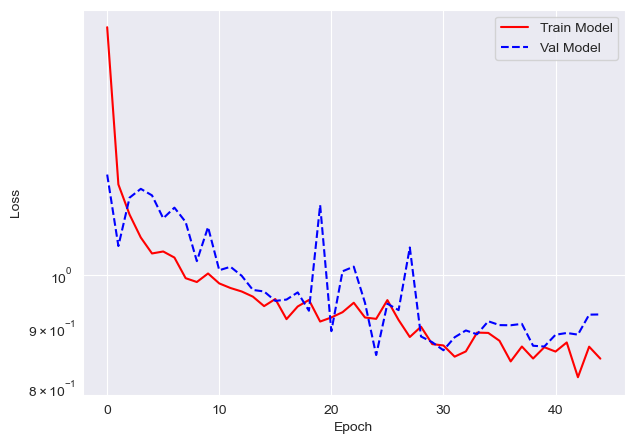

In [38]:
plot_loss(fm_2)

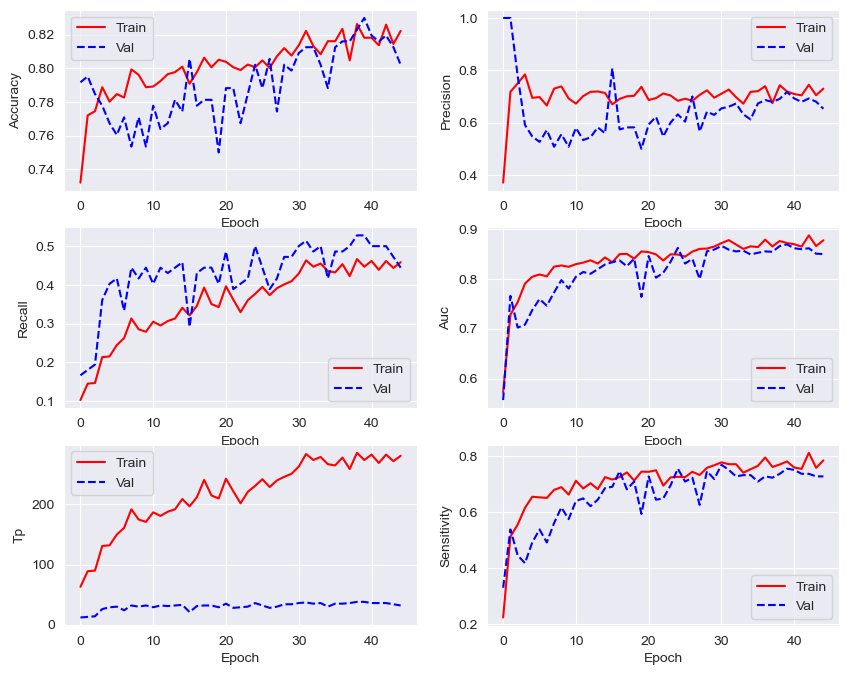

In [39]:
plot_metrics(fm_2)

In [40]:
result2 = model2.evaluate(test_dataset)

20/20 [==============================] - 2s 78ms/step - loss: 1.5472 - tp: 71.0000 - fp: 94.0000 - tn: 851.0000 - fn: 244.0000 - accuracy: 0.7317 - precision: 0.4303 - recall: 0.2254 - auc: 0.6294 - sensitivity: 0.3217


In [41]:
model2_b = load_model('model.hdf5')
print('Best model from file:')
result2_b = model2_b.evaluate(test_dataset)

Best model from file:
20/20 [==============================] - 2s 74ms/step - loss: 0.9950 - tp: 107.0000 - fp: 44.0000 - tn: 901.0000 - fn: 208.0000 - accuracy: 0.8000 - precision: 0.7086 - recall: 0.3397 - auc: 0.8035 - sensitivity: 0.6254


In [42]:
model3 = Sequential()

model3.add(Conv2D(8, kernel_size=(3, 3), input_shape=(224, 224,3), padding='same', data_format='channels_last'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(32, kernel_size=(3,3), padding='same', kernel_regularizer = regularizers.l2(1e-3)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.3))

model3.add(Flatten())
model3.add(Dense(256, kernel_regularizer = regularizers.l2(1e-3)))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(4, activation='softmax'))

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 224, 224, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 8)       0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 8)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 32)      2336      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)    

In [43]:
fm_3=f_model(model3)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 56.1878 - tp: 215.0000 - fp: 397.0000 - tn: 1442.0000 - fn: 398.0000 - accuracy: 0.6758 - precision: 0.3513 - recall: 0.3507 - auc: 0.5648 - sensitivity: 0.0000e+00
Epoch 1: val_loss improved from inf to 2.95928, saving model to model.hdf5
20/20 [==============================] - 11s 493ms/step - loss: 56.1878 - tp: 215.0000 - fp: 397.0000 - tn: 1442.0000 - fn: 398.0000 - accuracy: 0.6758 - precision: 0.3513 - recall: 0.3507 - auc: 0.5648 - sensitivity: 0.0000e+00 - val_loss: 2.9593 - val_tp: 23.0000 - val_fp: 49.0000 - val_tn: 167.0000 - val_fn: 49.0000 - val_accuracy: 0.6597 - val_precision: 0.3194 - val_recall: 0.3194 - val_auc: 0.6413 - val_sensitivity: 0.4815 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 12.9755 - tp: 250.0000 - fp: 338.0000 - tn: 1501.0000 - fn: 363.0000 - accuracy: 0.7141 - precision: 0.4252 - recall: 0.4078 - auc: 0.6363 - sensitivity: 0.0756
Epoch 2: val_lo

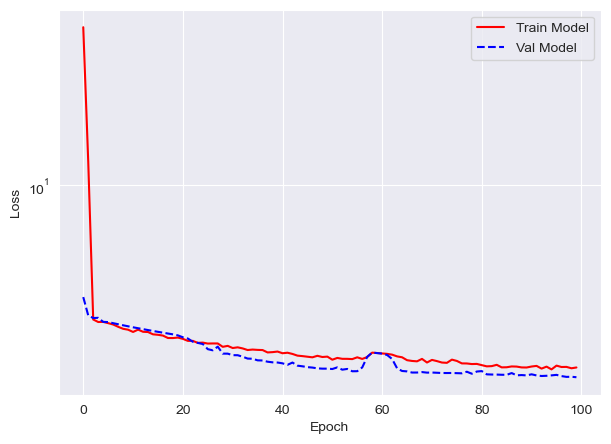

In [44]:
plot_loss(fm_3)

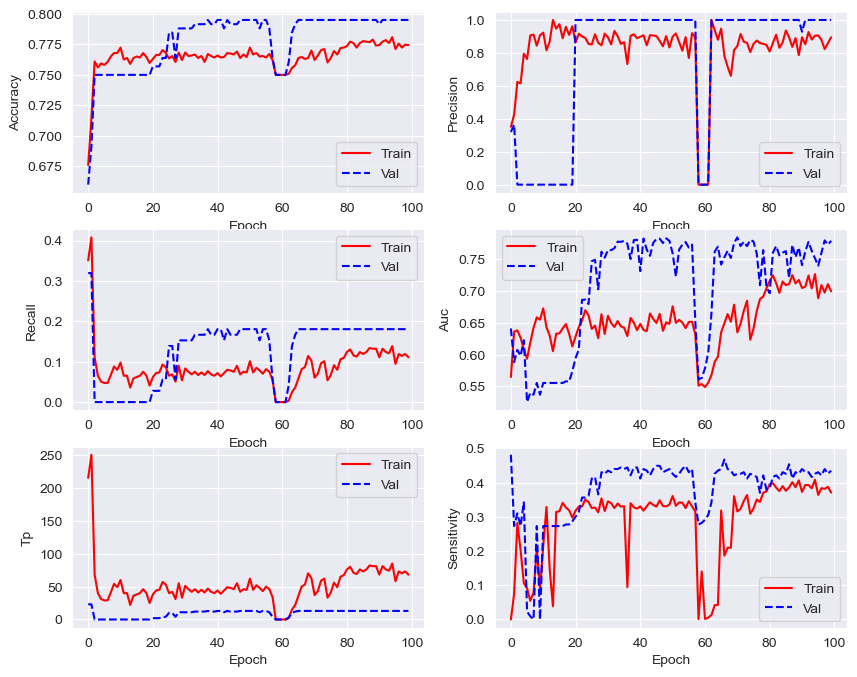

In [45]:
plot_metrics(fm_3)

In [46]:
result3 = model3.evaluate(test_dataset)

20/20 [==============================] - 1s 67ms/step - loss: 1.2679 - tp: 42.0000 - fp: 2.0000 - tn: 943.0000 - fn: 273.0000 - accuracy: 0.7817 - precision: 0.9545 - recall: 0.1333 - auc: 0.7820 - sensitivity: 0.6455


In [47]:
model3_b = load_model('model.hdf5')
print('Best model from file:')
result3_b = model3_b.evaluate(test_dataset)

Best model from file:
20/20 [==============================] - 2s 53ms/step - loss: 1.2679 - tp: 42.0000 - fp: 2.0000 - tn: 943.0000 - fn: 273.0000 - accuracy: 0.7817 - precision: 0.9545 - recall: 0.1333 - auc: 0.7820 - sensitivity: 0.6455


In [48]:
model4 = Sequential()

model4.add(Conv2D(8, kernel_size=(3, 3), input_shape=(224, 224,3), padding='same', data_format='channels_last'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(16, kernel_size=(3,3), padding='same', kernel_regularizer = regularizers.l2(1e-3)))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Dropout(0.4))
model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(4, activation='softmax'))

model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 8)       224       
                                                                 
 batch_normalization_2 (Batc  (None, 224, 224, 8)      32        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 224, 224, 8)       0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 16)      1168      
                                                                 
 batch_normalization_3 (Batc  (None, 112, 112, 16)    

In [49]:
fm_4 = f_model(model4)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 19.9098 - tp: 207.0000 - fp: 397.0000 - tn: 1442.0000 - fn: 406.0000 - accuracy: 0.6725 - precision: 0.3427 - recall: 0.3377 - auc: 0.5695 - sensitivity: 0.1044
Epoch 1: val_loss improved from inf to 4.32854, saving model to model.hdf5
20/20 [==============================] - 9s 400ms/step - loss: 19.9098 - tp: 207.0000 - fp: 397.0000 - tn: 1442.0000 - fn: 406.0000 - accuracy: 0.6725 - precision: 0.3427 - recall: 0.3377 - auc: 0.5695 - sensitivity: 0.1044 - val_loss: 4.3285 - val_tp: 23.0000 - val_fp: 40.0000 - val_tn: 176.0000 - val_fn: 49.0000 - val_accuracy: 0.6910 - val_precision: 0.3651 - val_recall: 0.3194 - val_auc: 0.5529 - val_sensitivity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 4.0671 - tp: 140.0000 - fp: 272.0000 - tn: 1567.0000 - fn: 473.0000 - accuracy: 0.6962 - precision: 0.3398 - recall: 0.2284 - auc: 0.5887 - sensitivity: 0.2795
Epoch 2: val_loss imp

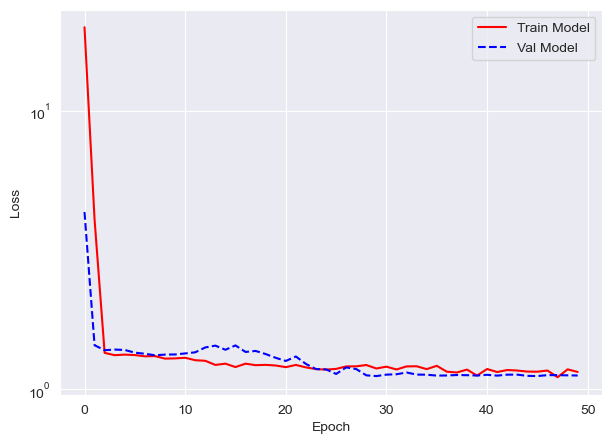

In [50]:
plot_loss(fm_4)

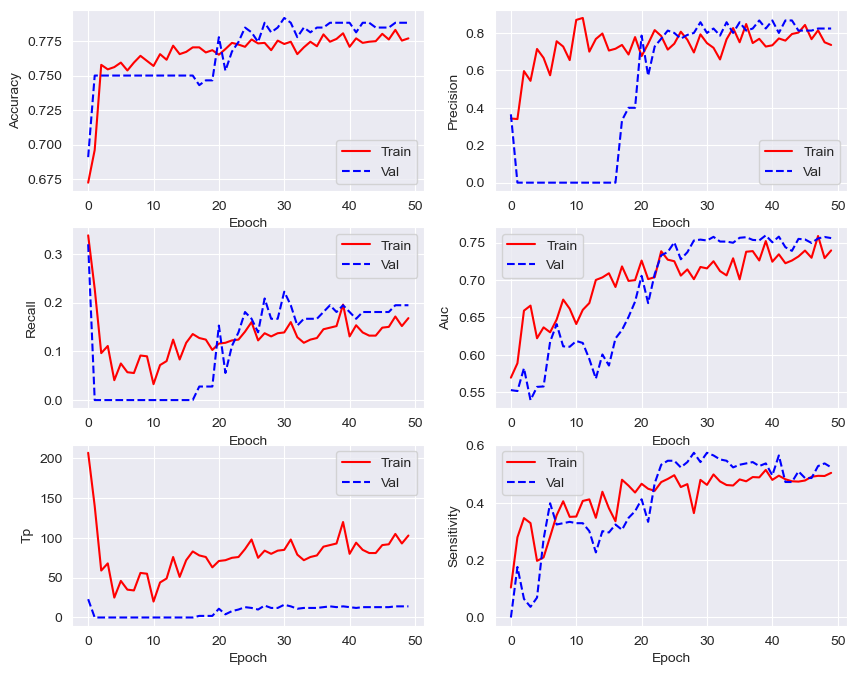

In [51]:
plot_metrics(fm_4)

In [52]:
result4 = model4.evaluate(test_dataset)

20/20 [==============================] - 1s 54ms/step - loss: 1.1669 - tp: 48.0000 - fp: 27.0000 - tn: 918.0000 - fn: 267.0000 - accuracy: 0.7667 - precision: 0.6400 - recall: 0.1524 - auc: 0.7368 - sensitivity: 0.5714


In [53]:
model4_b = load_model('model.hdf5')
print('Best model from file:')
result4_b = model4_b.evaluate(test_dataset)

Best model from file:
20/20 [==============================] - 2s 54ms/step - loss: 1.1079 - tp: 42.0000 - fp: 1.0000 - tn: 944.0000 - fn: 273.0000 - accuracy: 0.7825 - precision: 0.9767 - recall: 0.1333 - auc: 0.7653 - sensitivity: 0.6011


In [54]:
model5 = Sequential()

model5.add(Conv2D(8, kernel_size=(3, 3), input_shape=(224, 224,3), padding='same', data_format='channels_last'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Conv2D(32, kernel_size=(3,3), padding='same', kernel_regularizer = regularizers.l2(1e-3)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Dense(128, kernel_regularizer = regularizers.l2(1e-3)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Dropout(0.4))
model5.add(Flatten())
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(4, activation='softmax'))

model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 8)       224       
                                                                 
 batch_normalization_4 (Batc  (None, 224, 224, 8)      32        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 224, 224, 8)       0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 32)      2336      
                                                                 
 batch_normalization_5 (Batc  (None, 112, 112, 32)    

In [55]:
fm_5 = f_model(model5)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 18.3780 - tp: 205.0000 - fp: 364.0000 - tn: 1475.0000 - fn: 408.0000 - accuracy: 0.6852 - precision: 0.3603 - recall: 0.3344 - auc: 0.5779 - sensitivity: 0.0837
Epoch 1: val_loss improved from inf to 1.45459, saving model to model.hdf5
20/20 [==============================] - 9s 380ms/step - loss: 18.3780 - tp: 205.0000 - fp: 364.0000 - tn: 1475.0000 - fn: 408.0000 - accuracy: 0.6852 - precision: 0.3603 - recall: 0.3344 - auc: 0.5779 - sensitivity: 0.0837 - val_loss: 1.4546 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 72.0000 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5369 - val_sensitivity: 0.3657 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.4554 - tp: 37.0000 - fp: 28.0000 - tn: 1811.0000 - fn: 576.0000 - accuracy: 0.7537 - precision: 0.5692 - recall: 0.0604 - auc: 0.5463 - sensitivity: 0.1321
Epoch 2: val_

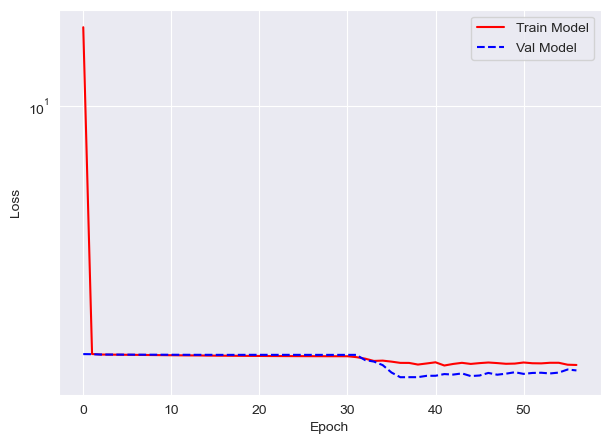

In [56]:
plot_loss(fm_5)

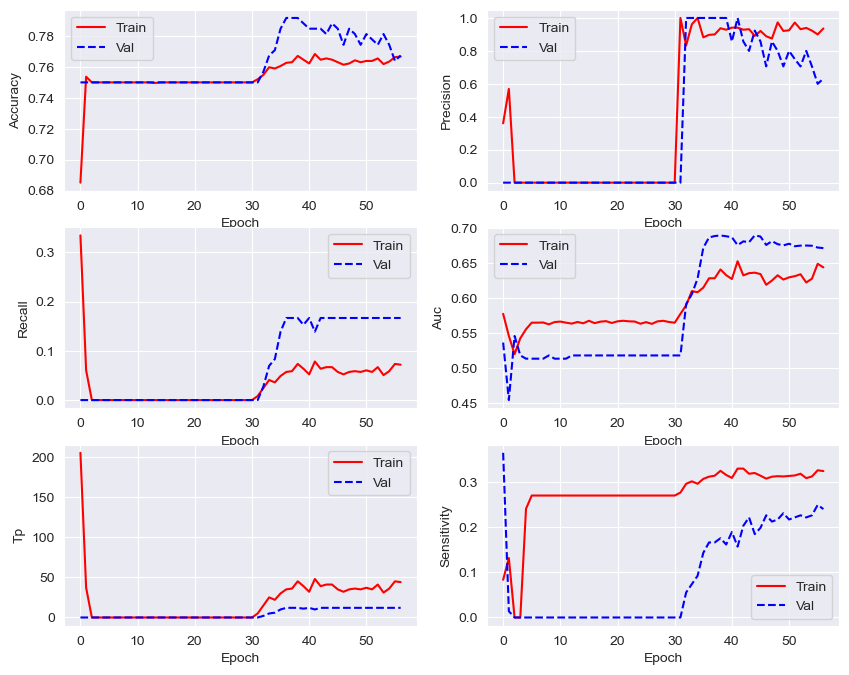

In [57]:
plot_metrics(fm_5)

In [58]:
result5 = model5.evaluate(test_dataset)

20/20 [==============================] - 1s 56ms/step - loss: 1.3730 - tp: 44.0000 - fp: 33.0000 - tn: 912.0000 - fn: 271.0000 - accuracy: 0.7587 - precision: 0.5714 - recall: 0.1397 - auc: 0.6530 - sensitivity: 0.2593


In [59]:
model5_b = load_model('model.hdf5')
print('Best model from file:')
result5_b = model5_b.evaluate(test_dataset)

Best model from file:
20/20 [==============================] - 2s 55ms/step - loss: 1.2633 - tp: 42.0000 - fp: 8.0000 - tn: 937.0000 - fn: 273.0000 - accuracy: 0.7770 - precision: 0.8400 - recall: 0.1333 - auc: 0.7108 - sensitivity: 0.3915


In [60]:
model6 = Sequential()
model6.add(Conv2D(16, kernel_size=(5, 5), input_shape=(224, 224,3), padding='same', activation='relu', data_format='channels_last'))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Dropout(0.35))

model6.add(Flatten())
model6.add(Dense(256, activation='relu'))
model6.add(Dropout(0.5))
model6.add(Dense(4, activation='softmax'))

model6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 224, 224, 16)      1216      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 64)      9280      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 56, 56, 64)        0         
                                                                 
 flatten_7 (Flatten)         (None, 200704)           

In [61]:
fm_6 = f_model(model6)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 3.2566 - tp: 76.0000 - fp: 193.0000 - tn: 1646.0000 - fn: 537.0000 - accuracy: 0.7023 - precision: 0.2825 - recall: 0.1240 - auc: 0.5332 - sensitivity: 0.1843
Epoch 1: val_loss improved from inf to 1.35621, saving model to model.hdf5
20/20 [==============================] - 21s 739ms/step - loss: 3.2566 - tp: 76.0000 - fp: 193.0000 - tn: 1646.0000 - fn: 537.0000 - accuracy: 0.7023 - precision: 0.2825 - recall: 0.1240 - auc: 0.5332 - sensitivity: 0.1843 - val_loss: 1.3562 - val_tp: 9.0000 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 63.0000 - val_accuracy: 0.7812 - val_precision: 1.0000 - val_recall: 0.1250 - val_auc: 0.6217 - val_sensitivity: 0.2407 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.2741 - tp: 57.0000 - fp: 25.0000 - tn: 1814.0000 - fn: 556.0000 - accuracy: 0.7631 - precision: 0.6951 - recall: 0.0930 - auc: 0.6973 - sensitivity: 0.4481
Epoch 2: val_loss improved f

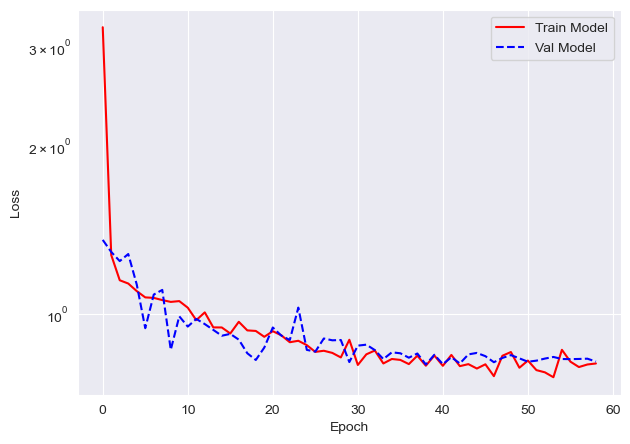

In [62]:
plot_loss(fm_6)

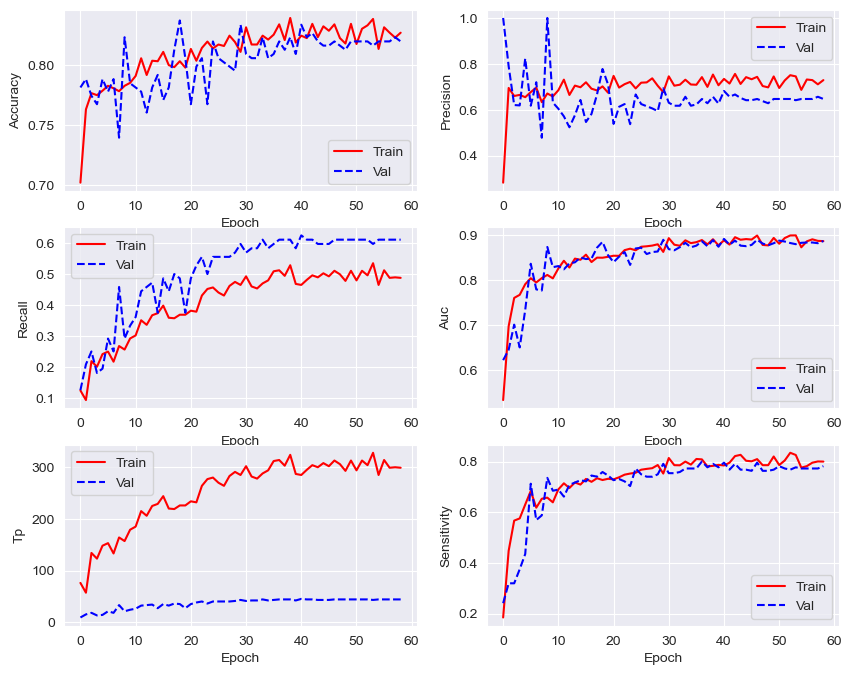

In [63]:
plot_metrics(fm_6)

In [64]:
result6 = model6.evaluate(test_dataset)

20/20 [==============================] - 2s 78ms/step - loss: 1.3788 - tp: 93.0000 - fp: 96.0000 - tn: 849.0000 - fn: 222.0000 - accuracy: 0.7476 - precision: 0.4921 - recall: 0.2952 - auc: 0.7108 - sensitivity: 0.4899


In [65]:
model6_b = load_model('model.hdf5')
print('Best model from file:')
result6_b = model6_b.evaluate(test_dataset)

Best model from file:
20/20 [==============================] - 2s 58ms/step - loss: 1.2856 - tp: 97.0000 - fp: 96.0000 - tn: 849.0000 - fn: 218.0000 - accuracy: 0.7508 - precision: 0.5026 - recall: 0.3079 - auc: 0.7355 - sensitivity: 0.5228


### Summarise

We can see that model 2 has best metrics, i.e. loss: 0.9950 - tp: 107.0000 - fp: 44.0000 - tn: 901.0000 - fn: 208.0000 - accuracy: 0.8000 - precision: 0.7086 - recall: 0.3397 - auc: 0.8035 - sensitivity: 0.6254.

## Transfer Learning

### InceptionV3

In [66]:
from keras.applications.inception_v3 import preprocess_input

def my_preprocess_input(x):
    x = preprocess_input(x)
    return x

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=my_preprocess_input)

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=my_preprocess_input)

test_datagen  = ImageDataGenerator(dtype='float32', preprocessing_function=my_preprocess_input)

In [67]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Data/train', target_size = (299,299), class_mode = 'categorical', batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = 'Data/valid', target_size = (299,299), class_mode = 'categorical', batch_size = 8)

test_dataset = test_datagen.flow_from_directory(directory = 'Data/test', target_size = (299,299), class_mode = 'categorical', batch_size = 16)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [68]:
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299, 3))
for layer in inception_model.layers:
    layer.trainable = False

In [69]:
model7 = Sequential()
model7.add(inception_model)
model7.add(Conv2D(8, kernel_size=(3, 3), input_shape=(299, 299,3), padding='same', activation='relu', data_format='channels_last'))
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Dropout(0.35))

model7.add(Flatten())
model7.add(Dense(256, activation='relu'))
model7.add(Dropout(0.5))
model7.add(Dense(4, activation='softmax'))

model7.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 conv2d_113 (Conv2D)         (None, 8, 8, 8)           147464    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 4, 4, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_114 (Conv2D)         (None, 4, 4, 32)          2336      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 2, 2, 32)         

In [70]:
fm_7 = f_model(model7)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.3628 - tp: 16.0000 - fp: 26.0000 - tn: 1813.0000 - fn: 597.0000 - accuracy: 0.7459 - precision: 0.3810 - recall: 0.0261 - auc: 0.6193 - sensitivity: 0.3116
Epoch 1: val_loss improved from inf to 1.26075, saving model to model.hdf5
20/20 [==============================] - 17s 627ms/step - loss: 1.3628 - tp: 16.0000 - fp: 26.0000 - tn: 1813.0000 - fn: 597.0000 - accuracy: 0.7459 - precision: 0.3810 - recall: 0.0261 - auc: 0.6193 - sensitivity: 0.3116 - val_loss: 1.2608 - val_tp: 6.0000 - val_fp: 6.0000 - val_tn: 210.0000 - val_fn: 66.0000 - val_accuracy: 0.7500 - val_precision: 0.5000 - val_recall: 0.0833 - val_auc: 0.6734 - val_sensitivity: 0.4167 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.1640 - tp: 107.0000 - fp: 69.0000 - tn: 1770.0000 - fn: 506.0000 - accuracy: 0.7655 - precision: 0.6080 - recall: 0.1746 - auc: 0.7487 - sensitivity: 0.5008
Epoch 2: val_loss improved from 1

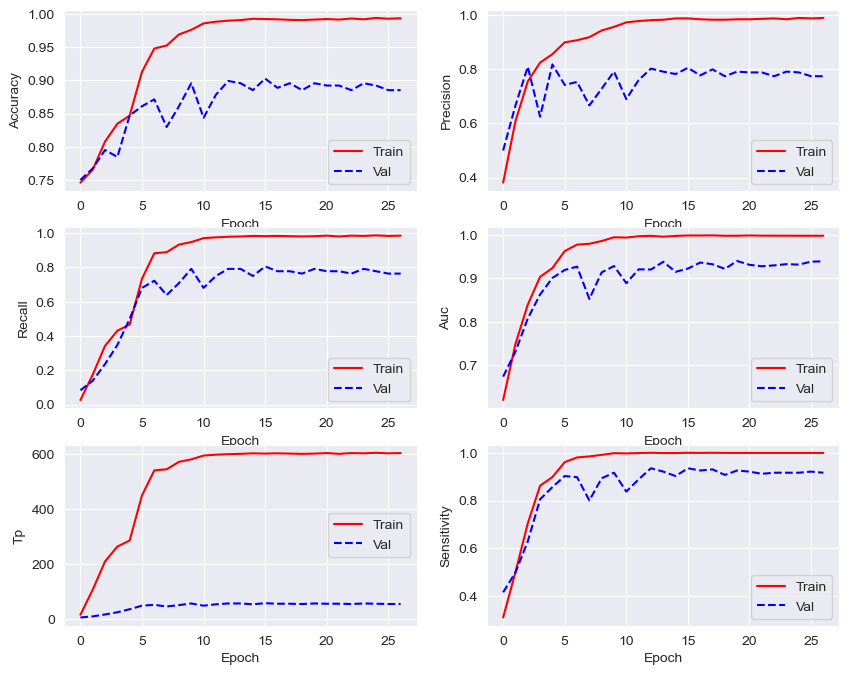

In [71]:
plot_metrics(fm_7)

In [72]:
result7 = model7.evaluate(test_dataset)

20/20 [==============================] - 4s 161ms/step - loss: 1.3679 - tp: 221.0000 - fp: 88.0000 - tn: 857.0000 - fn: 94.0000 - accuracy: 0.8556 - precision: 0.7152 - recall: 0.7016 - auc: 0.8789 - sensitivity: 0.8434


In [73]:
model7_b = load_model('model.hdf5')
print('Best model from file:')
result7_b = model7_b.evaluate(test_dataset)

Best model from file:
20/20 [==============================] - 7s 284ms/step - loss: 0.8839 - tp: 211.0000 - fp: 88.0000 - tn: 857.0000 - fn: 104.0000 - accuracy: 0.8476 - precision: 0.7057 - recall: 0.6698 - auc: 0.8938 - sensitivity: 0.8508


### ResNet50

In [74]:
train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

test_datagen  = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [75]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Data/train', target_size = (224,224), class_mode = 'categorical', batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = 'Data/valid', target_size = (224,224), class_mode = 'categorical', batch_size = 8)

test_dataset = test_datagen.flow_from_directory(directory = 'Data/test', target_size = (224,224), class_mode = 'categorical', batch_size = 16)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [76]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224, 3))
for layer in resnet_model.layers:
    layer.trainable = False

In [77]:
model8 = Sequential()
model8.add(resnet_model)
model8.add(Conv2D(8, kernel_size=(3, 3), input_shape=(224, 224,3), padding='same', activation='relu', data_format='channels_last'))
model8.add(MaxPooling2D(pool_size=(2,2)))
model8.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model8.add(MaxPooling2D(pool_size=(2,2)))
model8.add(Dropout(0.35))

model8.add(Flatten())
model8.add(Dense(256, activation='relu'))
model8.add(Dropout(0.5))
model8.add(Dense(4, activation='softmax'))

model8.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_115 (Conv2D)         (None, 7, 7, 8)           147464    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 3, 3, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_116 (Conv2D)         (None, 3, 3, 32)          2336      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 1, 1, 32)         0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 1, 1, 32)         

In [78]:
fm_8 = f_model(model8)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.3914 - tp: 37.0000 - fp: 39.0000 - tn: 1800.0000 - fn: 576.0000 - accuracy: 0.7492 - precision: 0.4868 - recall: 0.0604 - auc: 0.5745 - sensitivity: 0.2817
Epoch 1: val_loss improved from inf to 1.23439, saving model to model.hdf5
20/20 [==============================] - 41s 2s/step - loss: 1.3914 - tp: 37.0000 - fp: 39.0000 - tn: 1800.0000 - fn: 576.0000 - accuracy: 0.7492 - precision: 0.4868 - recall: 0.0604 - auc: 0.5745 - sensitivity: 0.2817 - val_loss: 1.2344 - val_tp: 12.0000 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 60.0000 - val_accuracy: 0.7917 - val_precision: 1.0000 - val_recall: 0.1667 - val_auc: 0.6437 - val_sensitivity: 0.2870 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.1293 - tp: 131.0000 - fp: 12.0000 - tn: 1827.0000 - fn: 482.0000 - accuracy: 0.7985 - precision: 0.9161 - recall: 0.2137 - auc: 0.7680 - sensitivity: 0.5922
Epoch 2: val_loss improved from

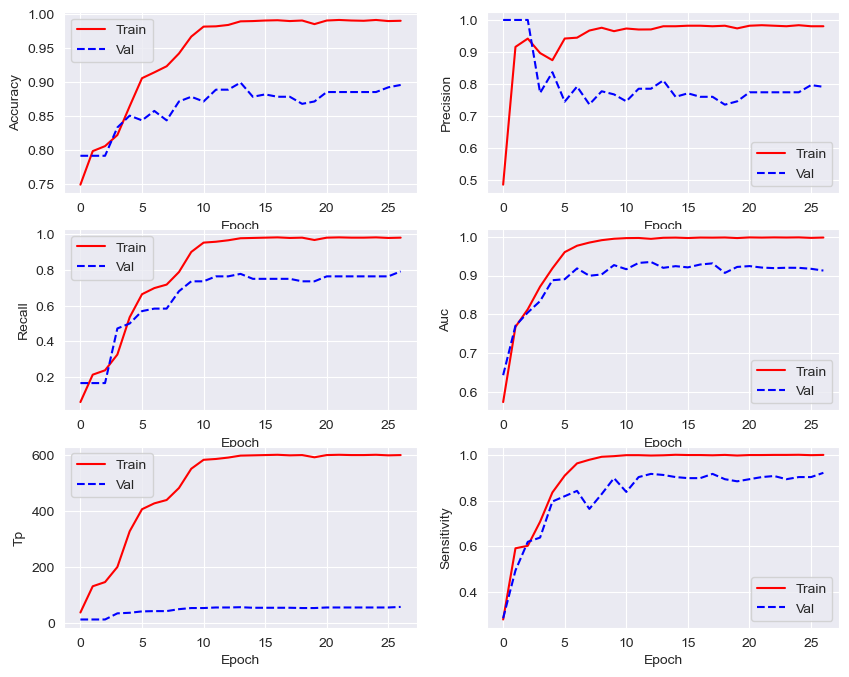

In [79]:
plot_metrics(fm_8)

In [80]:
result8 = model8.evaluate(test_dataset)

20/20 [==============================] - 16s 787ms/step - loss: 1.2992 - tp: 220.0000 - fp: 87.0000 - tn: 858.0000 - fn: 95.0000 - accuracy: 0.8556 - precision: 0.7166 - recall: 0.6984 - auc: 0.8819 - sensitivity: 0.8476


In [81]:
model8_b = load_model('model.hdf5')
print('Best model from file:')
result8_b = model8_b.evaluate(test_dataset)

Best model from file:
20/20 [==============================] - 17s 789ms/step - loss: 0.8011 - tp: 153.0000 - fp: 44.0000 - tn: 901.0000 - fn: 162.0000 - accuracy: 0.8365 - precision: 0.7766 - recall: 0.4857 - auc: 0.8960 - sensitivity: 0.8307


### VGG19

In [82]:
train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

test_datagen  = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

In [83]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Data/train', target_size = (224,224), class_mode = 'categorical', batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = 'Data/valid', target_size = (224,224), class_mode = 'categorical', batch_size = 8)

test_dataset = test_datagen.flow_from_directory(directory = 'Data/test', target_size = (224,224), class_mode = 'categorical', batch_size = 16)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [84]:
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224, 3))
for layer in vgg19_model.layers:
    layer.trainable = False

In [85]:
model9 = Sequential()
model9.add(vgg19_model)
model9.add(Conv2D(8, kernel_size=(3, 3), input_shape=(224, 224,3), padding='same', activation='relu', data_format='channels_last'))
model9.add(MaxPooling2D(pool_size=(2,2)))
model9.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model9.add(MaxPooling2D(pool_size=(2,2)))
model9.add(Dropout(0.35))

model9.add(Flatten())
model9.add(Dense(256, activation='relu'))
model9.add(Dropout(0.5))
model9.add(Dense(4, activation='softmax'))

model9.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d_117 (Conv2D)         (None, 7, 7, 8)           36872     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 3, 3, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_118 (Conv2D)         (None, 3, 3, 32)          2336      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 1, 1, 32)         0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 1, 1, 32)        

In [86]:
fm_9 = f_model(model9)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.9980 - tp: 77.0000 - fp: 176.0000 - tn: 1663.0000 - fn: 536.0000 - accuracy: 0.7096 - precision: 0.3043 - recall: 0.1256 - auc: 0.5460 - sensitivity: 0.2191
Epoch 1: val_loss improved from inf to 1.32704, saving model to model.hdf5
20/20 [==============================] - 25s 1s/step - loss: 1.9980 - tp: 77.0000 - fp: 176.0000 - tn: 1663.0000 - fn: 536.0000 - accuracy: 0.7096 - precision: 0.3043 - recall: 0.1256 - auc: 0.5460 - sensitivity: 0.2191 - val_loss: 1.3270 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 71.0000 - val_accuracy: 0.7535 - val_precision: 1.0000 - val_recall: 0.0139 - val_auc: 0.6993 - val_sensitivity: 0.3889 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.2649 - tp: 67.0000 - fp: 24.0000 - tn: 1815.0000 - fn: 546.0000 - accuracy: 0.7675 - precision: 0.7363 - recall: 0.1093 - auc: 0.6865 - sensitivity: 0.4078
Epoch 2: val_loss improved from

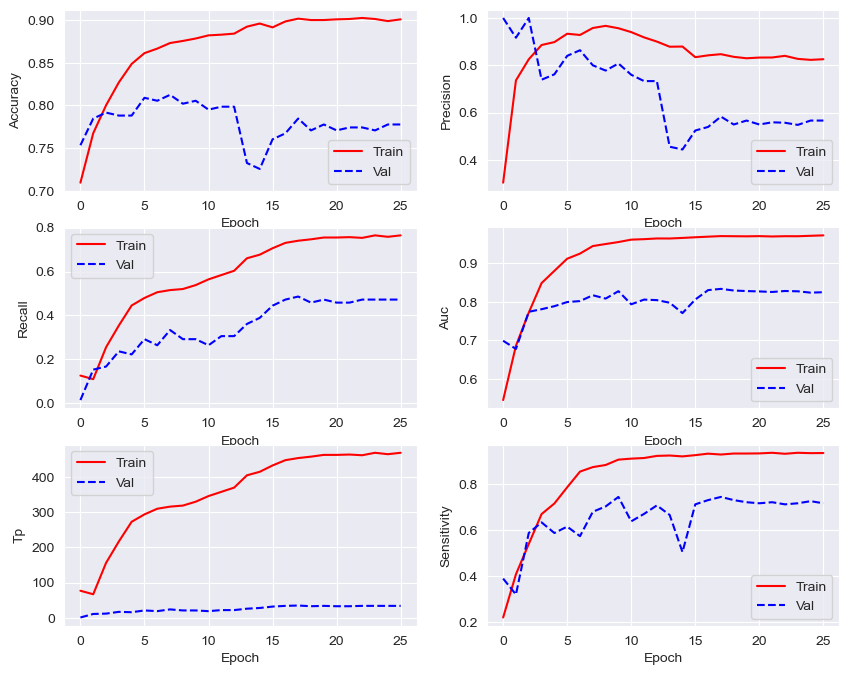

In [87]:
plot_metrics(fm_9)

In [88]:
result9 = model9.evaluate(test_dataset)

20/20 [==============================] - 11s 547ms/step - loss: 0.9244 - tp: 173.0000 - fp: 76.0000 - tn: 869.0000 - fn: 142.0000 - accuracy: 0.8270 - precision: 0.6948 - recall: 0.5492 - auc: 0.8691 - sensitivity: 0.7524


In [89]:
model9_b = load_model('model.hdf5')
print('Best model from file:')
result9_b = model9_b.evaluate(test_dataset)

Best model from file:
20/20 [==============================] - 12s 555ms/step - loss: 0.9857 - tp: 105.0000 - fp: 23.0000 - tn: 922.0000 - fn: 210.0000 - accuracy: 0.8151 - precision: 0.8203 - recall: 0.3333 - auc: 0.8241 - sensitivity: 0.6868


### Summarise

We can see that all pre-trained models gives us better result that defining our own CNN.